In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf

import logging

# configure logging at the root level of Lightning
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

%matplotlib inline
%load_ext tensorboard
sns.set_theme()

# Settings

In [28]:
train_size = 0.80 # train/test split
subsample = False # whether to randomly subsample the training data
subsample_size = 0.2 # fraction of training data to keep

# list of stock tickers to use, top 3 from S&P 500 sector by market cap
stock_tickers = ["META", "GOOGL", "NFLX", "AMZN", "TSLA", "HD", "PG", "COST", "PEP", "XOM", "CVX", "COP", "MA", "JPM", "V", "UNH", "JNJ", "LLY", "UNP", "BA", "CAT", "LIN", "SHW", "FCX", "PLD", "AMT", "EQIX", "MSFT", "AAPL", "AVGO", "NEE", "SO", "DUK"]

lookback_window = 90 # num of days to look back
lookahead_window = 1 # num of days to look ahead

input_size = 2 # num feature channels (price, volume, sentiment, etc)
num_layers = 8 # num of stacked LSTM layers
hidden_size = 64 # num of nodes per LSTM layer

max_epochs = 100 # max num of epochs to train for per ticker
learning_rate = 1e-4 # learning rate
batch_size = 256
shuffle_train = False
accelerator = "gpu"

# Model Setup

In [3]:
class StockPricePredictor(L.LightningModule):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 output_size: int,
                 learning_rate: float,
                 train_losses: list[int],
                 test_losses: list[int]):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.train_losses = train_losses
        self.test_losses = test_losses
        self.learning_rate = learning_rate
    
    def forward(self, x: torch.Tensor):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, on_step=True, prog_bar=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, on_step=True, prog_bar=False)
        return loss
    
    def on_train_epoch_end(self):
        self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        self.test_losses.append(self.trainer.callback_metrics["val_loss"].item())

# Dataset Preparation

In [4]:
import pickle as pkl

with open("../data/final/sp500-price-volume.pkl", "rb") as f:
    sp500_df = pkl.load(f)

with open("../data/final/sp500-price-volume-sentiment.pkl", "rb") as f:
    sp500_sentiment_df = pkl.load(f)


In [5]:
sp500_sentiment_df

,Date,Ticker,Price,Volume,Sentiment
0,2013-12-23,AAPL,20.360357,501306400,0.0
1,2013-12-24,AAPL,20.273930,167554800,0.0
2,2013-12-26,AAPL,20.139286,204008000,0.0
3,2013-12-27,AAPL,20.003214,225884400,0.0
4,2013-12-30,AAPL,19.804285,253629600,0.0
...,...,...,...,...,...
83089,2023-12-18,XOM,101.650002,21610400,0.0
83090,2023-12-19,XOM,102.989998,18904700,0.0
83091,2023-12-20,XOM,101.269997,20988900,0.0
83092,2023-12-21,XOM,101.730003,19250900,0.0


In [6]:
sp500_df["Ticker"] = sp500_df["Ticker"].astype("category")
sp500_df["Date"] = sp500_df["Date"].astype("datetime64[ns]")
sp500_df["Price"] = pd.to_numeric(sp500_df["Price"], errors="coerce", downcast="float")
sp500_df["Volume"] = pd.to_numeric(sp500_df["Volume"], errors="coerce", downcast="integer")

sp500_sentiment_df["Ticker"] = sp500_sentiment_df["Ticker"].astype("category")
sp500_sentiment_df["Date"] = sp500_sentiment_df["Date"].astype("datetime64[ns]")
sp500_sentiment_df["Sentiment"] = pd.to_numeric(sp500_sentiment_df["Sentiment"], errors="coerce", downcast="float")
sp500_sentiment_df["Price"] = pd.to_numeric(sp500_sentiment_df["Price"], errors="coerce", downcast="float")
sp500_sentiment_df["Volume"] = pd.to_numeric(sp500_sentiment_df["Volume"], errors="coerce", downcast="integer")

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def split_data(df: pd.DataFrame,
               train_size: float = 0.8,
               lbp: int = 30,
               lfp: int = 1) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    """
    lbp: look back period
    lfp: look forward period
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    test_tickers = []

    tickers = df["Ticker"].unique()

    for ticker in tickers:
        ticker_df = df[df["Ticker"] == ticker]
        ticker_df = ticker_df.drop("Ticker", axis=1)
        ticker_df = ticker_df.set_index("Date")
        ticker_array = ticker_df.sort_index().values
        
        train_count = int(ticker_array.shape[0] * train_size)
        train = ticker_array[:train_count]
        test = ticker_array[train_count:]

        ticker_X_train = []
        ticker_y_train = []
        ticker_X_test = []
        ticker_y_test = []


        for i in range(lbp, train.shape[0] - lfp + 1):
            ticker_X_train.append(train[i - lbp:i, :])
            ticker_y_train.append(train[i:i + lfp, 0])
        
        for i in range(lbp, test.shape[0] - lfp + 1):
            ticker_X_test.append(test[i - lbp:i, :])
            ticker_y_test.append(test[i:i + lfp, 0])
            test_tickers.append(ticker)

        X_train.append(ticker_X_train)
        y_train.append(ticker_y_train)
        X_test.append(ticker_X_test)
        y_test.append(ticker_y_test)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_train = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2], -1)
    X_test = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2], -1)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape[0] * y_train.shape[1], y_train.shape[2])
    y_test = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape[0] * y_test.shape[1], y_test.shape[2])

    return X_train, y_train, X_test, y_test, y_scaler

(X_train_no_sentiment, y_train_no_sentiment, X_test_no_sentiment, y_test_no_sentiment, y_scaler_no_sentiment) = split_data(sp500_df, train_size=train_size, lbp=lookback_window, lfp=lookahead_window)
(X_train_sentiment, y_train_sentiment, X_test_sentiment, y_test_sentiment, y_scaler_sentiment) = split_data(sp500_sentiment_df, train_size=train_size, lbp=lookback_window, lfp=lookahead_window)

print(f"X_train_no_sentiment shape: {X_train_no_sentiment.shape}")
print(f"y_train_no_sentiment shape: {y_train_no_sentiment.shape}")
print(f"X_test_no_sentiment shape: {X_test_no_sentiment.shape}")
print(f"y_test_no_sentiment shape: {y_test_no_sentiment.shape}")
print()
print(f"X_train_sentiment shape: {X_train_sentiment.shape}")
print(f"y_train_sentiment shape: {y_train_sentiment.shape}")
print(f"X_test_sentiment shape: {X_test_sentiment.shape}")
print(f"y_test_sentiment shape: {y_test_sentiment.shape}")

X_train_no_sentiment shape: (63492, 90, 2)
y_train_no_sentiment shape: (63492, 1)
X_test_no_sentiment shape: (13662, 90, 2)
y_test_no_sentiment shape: (13662, 1)

X_train_sentiment shape: (63492, 90, 3)
y_train_sentiment shape: (63492, 1)
X_test_sentiment shape: (13662, 90, 3)
y_test_sentiment shape: (13662, 1)


In [9]:
from torch.utils.data import TensorDataset, DataLoader

no_sentiment_train_dataset = TensorDataset(torch.from_numpy(X_train_no_sentiment).float(), torch.from_numpy(y_train_no_sentiment).float())
no_sentiment_test_dataset = TensorDataset(torch.from_numpy(X_test_no_sentiment).float(), torch.from_numpy(y_test_no_sentiment).float())

sentiment_train_dataset = TensorDataset(torch.from_numpy(X_train_sentiment).float(), torch.from_numpy(y_train_sentiment).float())
sentiment_test_dataset = TensorDataset(torch.from_numpy(X_test_sentiment).float(), torch.from_numpy(y_test_sentiment).float())

no_sentiment_train_dataloader = DataLoader(no_sentiment_train_dataset, batch_size=batch_size, shuffle=shuffle_train, num_workers=11, persistent_workers=True)
no_sentiment_test_dataloader = DataLoader(no_sentiment_test_dataset, batch_size=batch_size, shuffle=False, num_workers=11, persistent_workers=True)

sentiment_train_dataloader = DataLoader(sentiment_train_dataset, batch_size=batch_size, shuffle=shuffle_train, num_workers=11, persistent_workers=True)
sentiment_test_dataloader = DataLoader(sentiment_test_dataset, batch_size=batch_size, shuffle=False, num_workers=11, persistent_workers=True)

# Model Training

In [ ]:
no_sentiment_train_losses = []
no_sentiment_test_losses = []
sentiment_train_losses = []
sentiment_test_losses = []

no_sentiment_model = StockPricePredictor(2, hidden_size, num_layers, lookahead_window, learning_rate=learning_rate, train_losses=no_sentiment_train_losses, test_losses=no_sentiment_test_losses)
sentiment_model = StockPricePredictor(3, hidden_size, num_layers, lookahead_window, learning_rate=learning_rate, train_losses=sentiment_train_losses, test_losses=sentiment_test_losses)

no_sentiment_trainer = L.Trainer(max_epochs=max_epochs, accelerator=accelerator)
no_sentiment_trainer.fit(no_sentiment_model, no_sentiment_train_dataloader, no_sentiment_test_dataloader)

sentiment_trainer = L.Trainer(max_epochs=max_epochs, accelerator=accelerator)
sentiment_trainer.fit(sentiment_model, sentiment_train_dataloader, sentiment_test_dataloader)

no_sentiment_train_losses = np.array(no_sentiment_train_losses).reshape(-1, max_epochs)
no_sentiment_test_losses = np.array(no_sentiment_test_losses).reshape(-1, max_epochs)
sentiment_train_losses = np.array(sentiment_train_losses).reshape(-1, max_epochs)
sentiment_test_losses = np.array(sentiment_test_losses).reshape(-1, max_epochs)

print("Done")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.lineplot(data=no_sentiment_train_losses.mean(axis=0), ax=ax, label="Train loss")
sns.lineplot(data=no_sentiment_test_losses.mean(axis=0), ax=ax, label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (RMSE)")
print(f"Final RMSE: {no_sentiment_test_losses.mean(axis=0)[-1]}")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.lineplot(data=sentiment_train_losses.mean(axis=0), ax=ax, label="Train loss")
sns.lineplot(data=sentiment_test_losses.mean(axis=0), ax=ax, label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (RMSE)")
print(f"Final RMSE: {sentiment_test_losses.mean(axis=0)[-1]}")

## Forecasting Test (Open-loop forecasting)

In [ ]:
sp500_sentiment_df

RMSE (No Sentiment): 0.034
RMSE (Sentiment): 0.035
N = 474


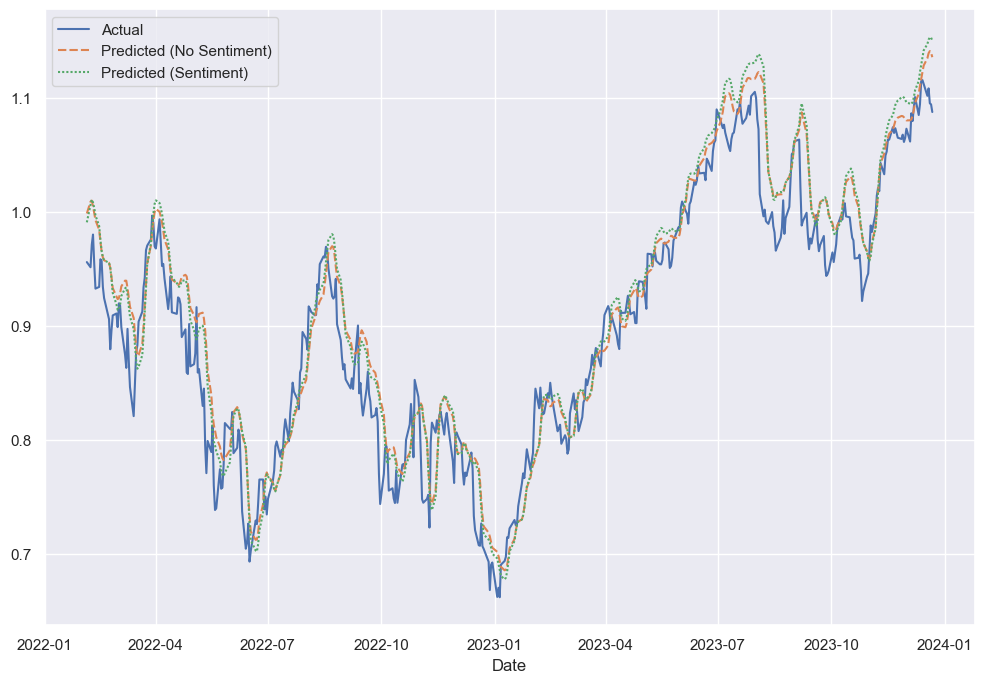

In [25]:
test_ticker = "AAPL"
no_sentiment_model.eval()
sentiment_model.eval()

# test_download = yf.download(
#     tickers=[test_ticker],
#     period="10y",
#     interval="1d",
# )

_, _, X_test_s, y_test_s, _ = split_data(sp500_df[sp500_df["Ticker"] == test_ticker], train_size=train_size, lbp=lookback_window, lfp=lookahead_window)
_, _, X_test_s_s, y_test_s_s, _ = split_data(sp500_sentiment_df[sp500_sentiment_df["Ticker"] == test_ticker], train_size=train_size, lbp=lookback_window, lfp=lookahead_window)

y_hat_s = []
y_hat_s_s = []

with torch.no_grad():
    for sample in X_test_s:
        torch_sample = torch.from_numpy(sample.reshape(1, lookback_window, -1)).float()
        y_hat_s.append(no_sentiment_model(torch_sample)[0,0])
    
    for sample in X_test_s_s:
        torch_sample = torch.from_numpy(sample.reshape(1, lookback_window, -1)).float()
        y_hat_s_s.append(sentiment_model(torch_sample)[0,0])


y_hat_s = np.array(y_hat_s)
y_hat_s_s = np.array(y_hat_s_s)

y_test = y_test_s.reshape(-1)

df_plot = pd.DataFrame({
    "Actual": y_test,
    "Predicted (No Sentiment)": y_hat_s,
    "Predicted (Sentiment)": y_hat_s_s,
}, index=sp500_df["Date"][-len(y_test):])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(df_plot, ax=ax)
print(f"RMSE (No Sentiment): {np.sqrt(np.mean((y_hat_s - y_test) ** 2)):.3f}")
print(f"RMSE (Sentiment): {np.sqrt(np.mean((y_hat_s_s - y_test) ** 2)):.3f}")
print(f"N = {len(y_test)}")

In [ ]:
from tqdm.notebook import trange
# Paired t-test

# get predictions from each model
no_sentiment_model.eval()
sentiment_model.eval()

y_hat_no_sentiment = []
y_hat_sentiment = []

for sample in trange(X_test_sentiment.shape[0]):
    ns_X = torch.from_numpy(X_test_no_sentiment[sample, :, :]).float().reshape(1, lookback_window, -1)
    s_X = torch.from_numpy(X_test_sentiment[sample, :, :]).float().reshape(1, lookback_window, -1)

    y_hat_no_sentiment.append(no_sentiment_model(ns_X)[0,0].item())
    y_hat_sentiment.append(sentiment_model(s_X)[0,0].item())

y_hat_no_sentiment = np.array(y_hat_no_sentiment)
y_hat_sentiment = np.array(y_hat_sentiment)

Text(0, 0.5, 'Count')

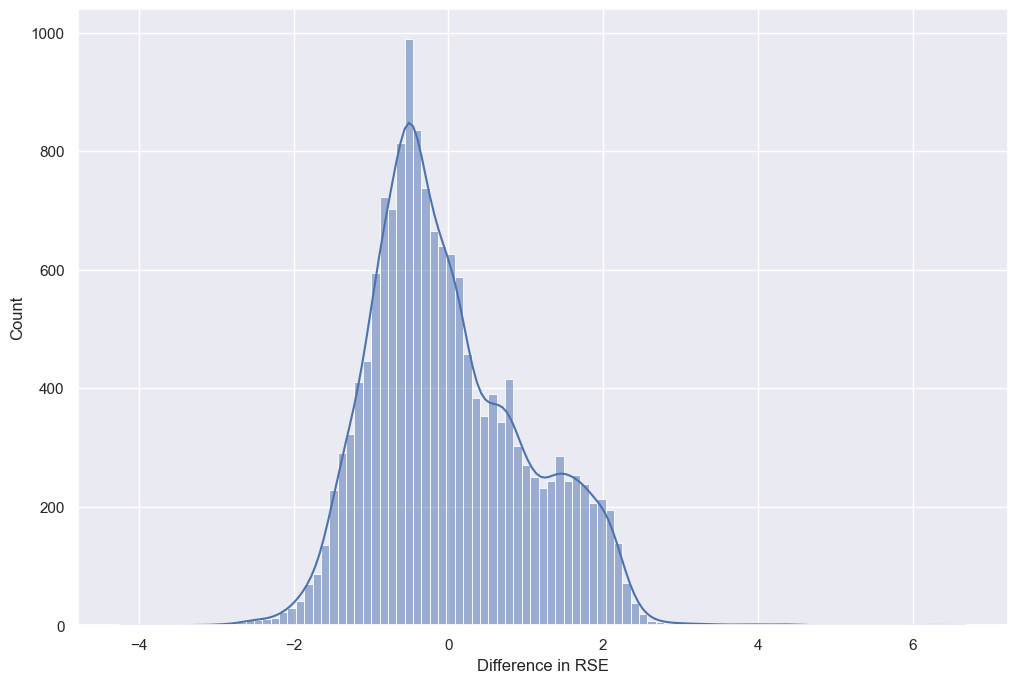

In [26]:
y_actual = y_test_sentiment.reshape(-1)

y_hat_sentiment_error = np.sqrt((y_hat_sentiment - y_actual) ** 2)
y_hat_no_sentiment_error = np.sqrt((y_hat_no_sentiment - y_actual) ** 2)

y_hat_diff = y_hat_sentiment_error - y_hat_no_sentiment_error

# normalize the difference
y_hat_diff = (y_hat_diff - y_hat_diff.mean()) / y_hat_diff.std()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(y_hat_diff, ax=ax, kde=True)
ax.set_xlabel("Difference in RSE")
ax.set_ylabel("Count")

In [27]:
print("No Sentiment")
print(f"Mean RMSE: {y_hat_no_sentiment_error.mean():.3f}")
print(f"Std RMSE: {y_hat_no_sentiment_error.std():.3f}")
print()
print("With Sentiment")
print(f"Mean RMSE: {y_hat_sentiment_error.mean():.3f}")
print(f"Std RMSE: {y_hat_sentiment_error.std():.3f}")

No Sentiment
Mean RMSE: 0.010
Std RMSE: 0.010

With Sentiment
Mean RMSE: 0.008
Std RMSE: 0.009


(0.0, 0.05)

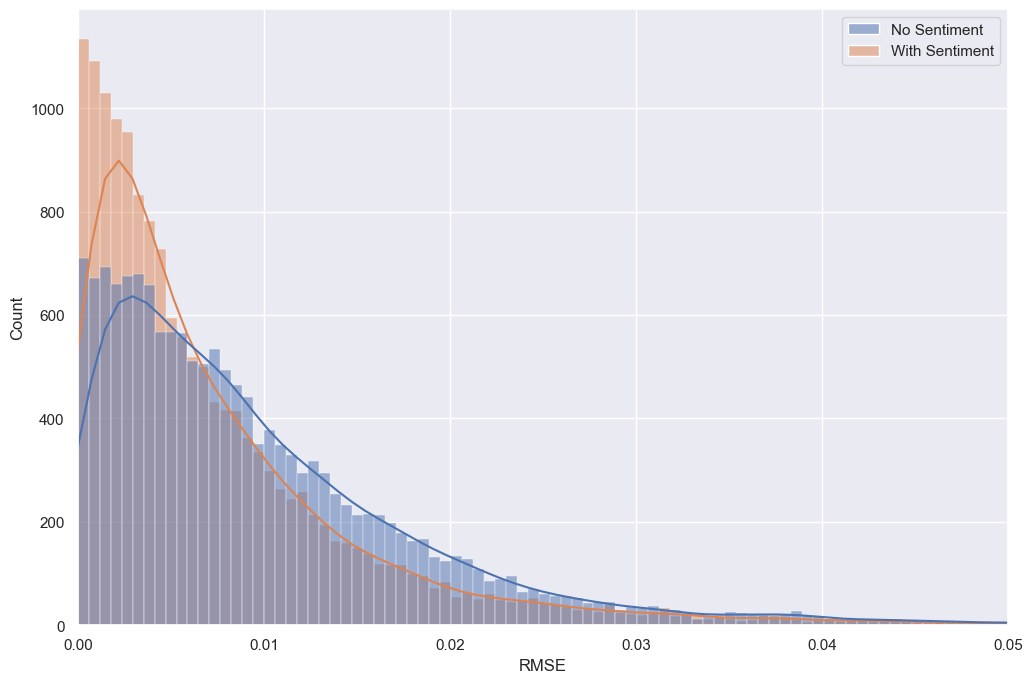

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# plot hists
sns.histplot(pd.DataFrame({
    "No Sentiment": y_hat_no_sentiment_error,
    "With Sentiment": y_hat_sentiment_error,
}), ax=ax, fill=True, kde=True, alpha=0.5)
ax.set_xlabel("RMSE")
ax.set_ylabel("Count")
ax.set_xlim(0, 0.05)

## Shapiro test for normality

pvalue < 0.05 => reject null hypothesis => not normal distribution

In [29]:
from scipy.stats import shapiro

shapiro(y_hat_diff)

/Users/pranav/Projects/cos497/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9685742855072021, pvalue=0.0)

### Wilcoxon Signed Rank Test

Tests whether the distributions of two paired samples are equal or not.

In [30]:
from scipy.stats import wilcoxon

wilcoxon(y_hat_sentiment_error, y_hat_no_sentiment_error, alternative="less")

WilcoxonResult(statistic=33532695.5, pvalue=0.0)

### Paired t-test

Isn't the best because differences are not normally distributed.

In [31]:
diff_mean = y_hat_diff.mean()
diff_std = y_hat_diff.std()
diff_n = y_hat_diff.shape[0]
diff_se = diff_std / np.sqrt(diff_n)
t_stat = diff_mean / diff_se

print(f"Mean of differences: {diff_mean:.3f}")
print(f"Std of differences: {diff_std:.3f}")
print(f"N: {diff_n} (df = {diff_n - 1})")
print(f"Standard Error: {diff_se:.3f}")
print(f"t-stat: {t_stat:.3f}")

Mean of differences: 0.000
Std of differences: 1.000
N: 15642 (df = 15641)
Standard Error: 0.008
t-stat: 0.000


In [ ]:
from scipy.stats import ttest_rel

ttest_rel(y_hat_sentiment_error, y_hat_no_sentiment_error, alternative="less")

In [ ]:
# import pickle as pkl

# with open(f"./v8/lookback-{lookback_window}/no-sentiment-model.pkl", "wb") as f:
#     pkl.dump(no_sentiment_model, f)

# with open(f"./v8/lookback-{lookback_window}/sentiment-model.pkl", "wb") as f:
#     pkl.dump(sentiment_model, f)

# with open(f"./v8/lookback-{lookback_window}/no-sentiment-scaler.pkl", "wb") as f:
#     pkl.dump(y_scaler_no_sentiment, f)

# with open(f"./v8/lookback-{lookback_window}/sentiment-scaler.pkl", "wb") as f:
#     pkl.dump(y_scaler_sentiment, f)

# with open(f"./v8/lookback-{lookback_window}/no-sentiment-train-losses.pkl", "wb") as f:
#     pkl.dump(no_sentiment_train_losses, f)

# with open(f"./v8/lookback-{lookback_window}/no-sentiment-test-losses.pkl", "wb") as f:
#     pkl.dump(no_sentiment_test_losses, f)

# with open(f"./v8/lookback-{lookback_window}/sentiment-train-losses.pkl", "wb") as f:
#     pkl.dump(sentiment_train_losses, f)

# with open(f"./v8/lookback-{lookback_window}/sentiment-test-losses.pkl", "wb") as f:
#     pkl.dump(sentiment_test_losses, f)
    
# print("Done")